Characters: 66741
Raw tokens: 12593 | Words a–z: 10377


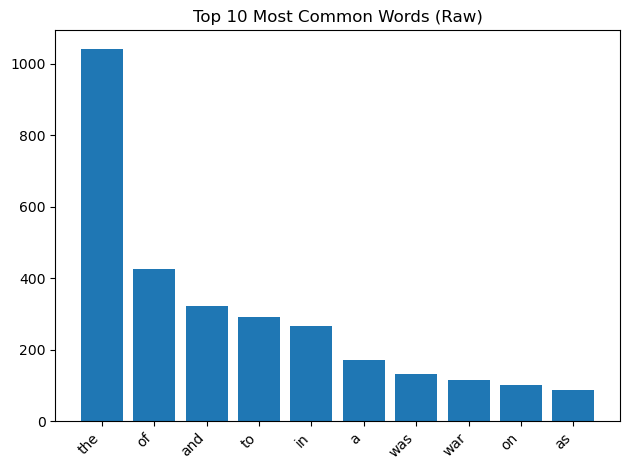

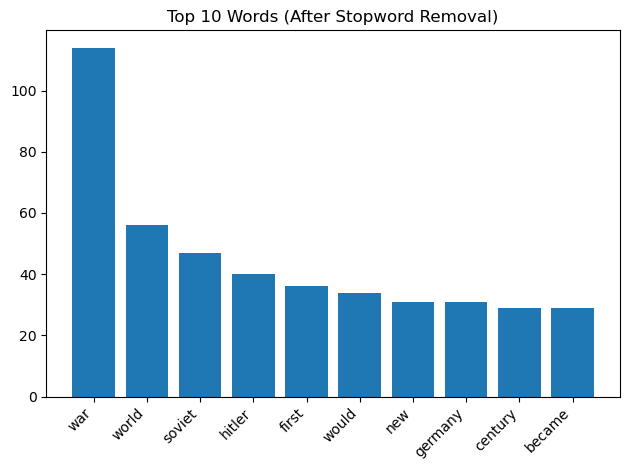

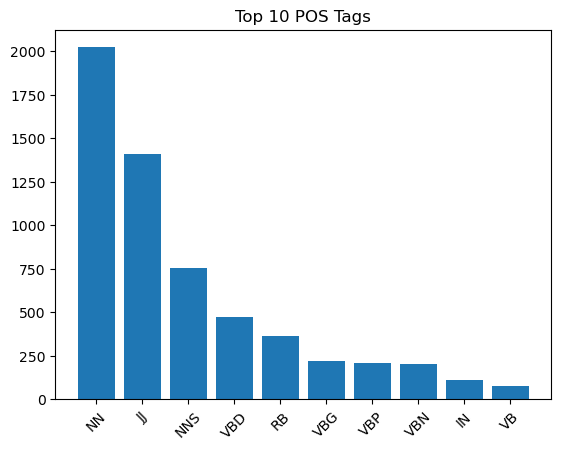

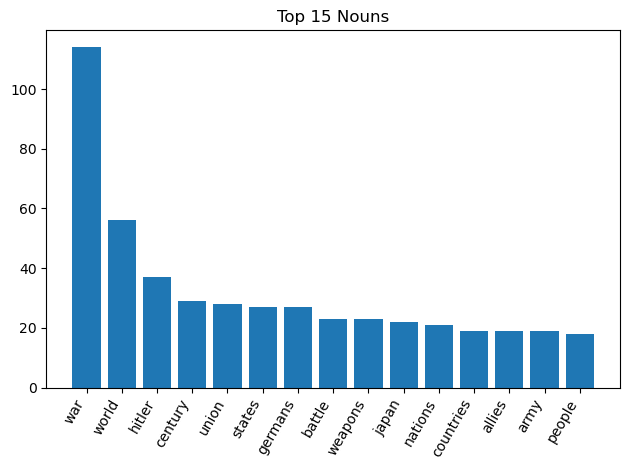

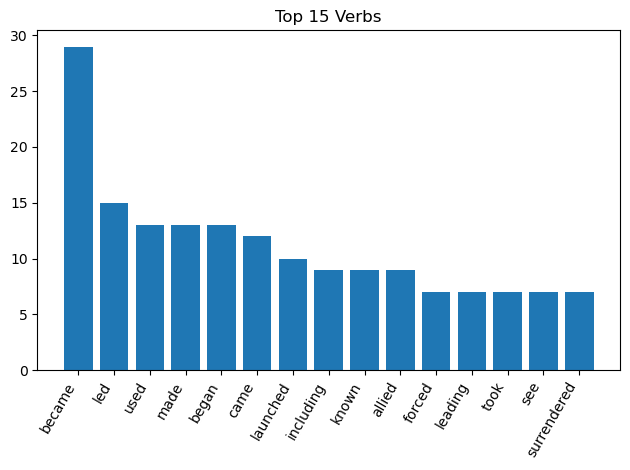

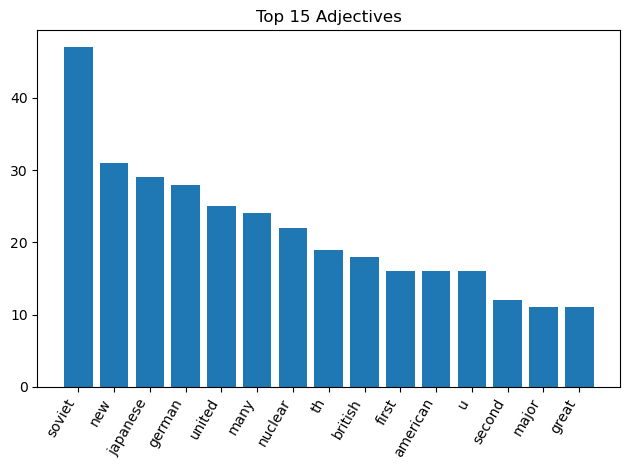

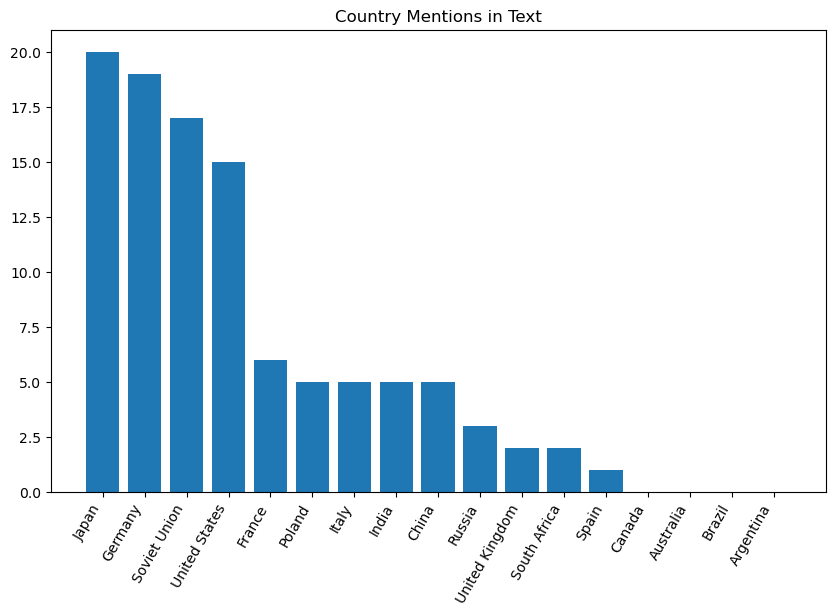

,country,mentions
7,Japan,20
1,Germany,19
4,Soviet Union,17
0,United States,15
2,France,6
11,Poland,5
9,Italy,5
8,India,5
6,China,5
5,Russia,3


In [31]:
# === Exercise 1.5: Text Mining ===
import os, re, warnings, pathlib
from collections import Counter
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from textblob import TextBlob
from bs4 import BeautifulSoup

# --- Ensure required NLTK resources ---
for pkg in ["punkt","punkt_tab","stopwords","averaged_perceptron_tagger",
            "averaged_perceptron_tagger_eng","wordnet","omw-1.4"]:
    try:
        nltk.data.find(pkg)
    except LookupError:
        nltk.download(pkg, quiet=True)

# --- Load text ---
TXT_PATH = "key_events_20th_century_text.txt"
HTML_PATH = "key_events_20th_century_raw.html"
if os.path.exists(TXT_PATH):
    text = open(TXT_PATH,encoding="utf-8").read()
else:
    html = open(HTML_PATH,encoding="utf-8").read()
    soup = BeautifulSoup(html,"lxml")
    text = " ".join(p.get_text(" ",strip=True) for p in soup.find_all("p"))
print("Characters:",len(text))

# --- Tokenization ---
tokens = word_tokenize(text.lower())
words_raw = re.findall(r"[a-z]+(?:'[a-z]+)?"," ".join(tokens))
print("Raw tokens:",len(tokens),"| Words a–z:",len(words_raw))

# --- Helper function ---
def bar_plot(items,title,xlabel="word",ylabel="count",rotation=45):
    df=pd.DataFrame(items,columns=[xlabel,ylabel])
    plt.figure()
    plt.bar(df[xlabel],df[ylabel])
    plt.title(title)
    plt.xticks(rotation=rotation,ha="right")
    plt.tight_layout()
    plt.show()
    return df

# --- Top 10 raw words ---
top10_raw=Counter(words_raw).most_common(10)
df_top10_raw=bar_plot(top10_raw,"Top 10 Most Common Words (Raw)")

# --- Remove stopwords ---
stop=set(stopwords.words("english"))
words_clean=[w for w in words_raw if w not in stop]
top10_clean=Counter(words_clean).most_common(10)
df_top10_clean=bar_plot(top10_clean,"Top 10 Words (After Stopword Removal)")

# --- POS tagging ---
blob=TextBlob(" ".join(words_clean))
tags=blob.tags
pos_counts=pd.Series([p for _,p in tags]).value_counts()
df_pos_top10=pos_counts.head(10).reset_index()
df_pos_top10.columns=["POS","count"]

plt.figure()
plt.bar(df_pos_top10["POS"],df_pos_top10["count"])
plt.title("Top 10 POS Tags")
plt.xticks(rotation=45)
plt.show()

# --- Top 15 nouns/verbs/adjectives ---
def plot_top_pos(prefix,title,n=15):
    sel=[w for w,p in tags if p.startswith(prefix)]
    freq=Counter(sel).most_common(n)
    return bar_plot(freq,title,"token","count",60)

plot_top_pos("NN","Top 15 Nouns")
plot_top_pos("VB","Top 15 Verbs")
plot_top_pos("JJ","Top 15 Adjectives")

# --- Country mentions ---
countries=["United States","Germany","France","United Kingdom","Soviet Union",
           "Russia","China","Japan","India","Italy","Spain","Poland",
           "Canada","Australia","South Africa","Brazil","Argentina"]
tlow=" "+text.lower()+" "
def count_phrase(txt,phrase): return txt.count(" "+phrase.lower()+" ")
rows=[(c,count_phrase(tlow,c)) for c in countries]
df_countries=pd.DataFrame(rows,columns=["country","mentions"]).sort_values("mentions",ascending=False)

plt.figure(figsize=(10,6))
plt.bar(df_countries["country"],df_countries["mentions"])
plt.title("Country Mentions in Text")
plt.xticks(rotation=60,ha="right")
plt.show()
df_countries
